In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from matplotlib.lines import Line2D
import time
from numpy.random import uniform
import scipy.stats

In [3]:
class LinearParticleFilter:
    def __init__(self, num_particles: int, world_size: np.ndarray, landmarks: np.ndarray, motion_noise_std: float, sensor_noise_std: float):
        '''
        num_particles: Number of particles tracked by the filter at every timestep
        world_size: Numpy array with row entries [min,max] value
        landmarks: Numpy array where each row contains coordinates for the centroid of a landmark
        motion_noise_std: Standard deviation of motion model noise term
        sensor_noise_std: Standard deviation of sensor model noise term
        '''
        self.particles = [] # np.array of floats, do not rename
        self.weights = [] # np.array of floats, do not rename
        self.num_particles = num_particles
        self.world_size = np.array([world_size])
        self.landmarks = landmarks
        self.motion_noise_std = motion_noise_std
        self.sensor_noise_std = sensor_noise_std
        
        self.sample_random_state() 
    
    def sample_random_state(self) -> float:
        '''
        Returns a random state within world_size bounds
        '''
        dim = self.world_size.shape[0]
        N = self.num_particles
        lim = self.world_size
        self.particles = np.zeros((N, dim))
        self.weights = np.ones((N, dim)) / N 
        
        for i in range(dim):        
            self.particles[:, i] = np.random.uniform(lim[i][0], lim[i][1], size=N)
         
        
        return self.particles
    
        
    def predict(self, u: np.ndarray):
        '''
        u: Motion update (np.ndarray indicating movement distance)
        motion_noise_std: Motion model uncertainty
        Update particle positions by u, while incorporating 0-mean Gaussian noise with stdev=motion_noise_std
        '''
        N = self.num_particles
        dim = self.world_size.shape[0]
        self.particles = self.particles.reshape(N,dim)
        self.weights = self.weights.reshape(N,1)
        noise = np.random.normal(0, self.motion_noise_std, size=(N, dim))
        move1 = noise + u
        
        self.particles = self.particles + move1
        
        self.particles = self.particles.flatten()
        self.weights = self.weights.flatten()

             
    def update(self, z: np.ndarray):
        '''
        z: Distance from agent to the nearest observable landmark
        Update particle weights using sensor reading z, which gives the distance to the nearest landmark.
        Particle weights should be updated using a Gaussian model centered at z. 
        Each weight must be the probability mass within a Gaussian, based on the difference between
        that particle's distance to the closest landmark and the distribution's mean (z),
        with stddev=sensor_noise_std
        
        All particle weights must be normalized before returning from this function
        '''

        N = self.num_particles
        dim = self.world_size.shape[0]
        self.particles = self.particles.reshape(N,dim)
        self.weights = self.weights.reshape(N,1)
        nl = self.landmarks.T.shape[0] #number of landmarks
        dist = np.ones((N,1))
        dist2 = np.ones((N,1))*1000
        z_pdf = scipy.stats.norm(z, self.sensor_noise_std)
        
        for i in range(nl):
            D = self.particles - self.landmarks.T[i, :]
            for j in range(N):
                dist[j,0] = np.linalg.norm(D[j,:])
            
            min_dist = np.minimum(dist, dist2)
            dist2 = min_dist
            
        for i in range(N):
            self.weights[i] = z_pdf.pdf(dist2[i]) 
        
        self.weights = self.weights/np.sum(self.weights)
        
        self.particles = self.particles.flatten()
        self.weights = self.weights.flatten()
        
    def resample(self):
        '''
        Sample new particles proportional to their weight.
        Your implementation should sample 80% of its particles from the existing batch
        and 20% of its particles should be sampled uniformly at random from the state space.

        '''
        N = self.num_particles
        dim = self.world_size.shape[0]
        self.particles = self.particles.reshape(N,dim)
        self.weights = self.weights.reshape(N,1)
        lim = self.world_size
        ns = int(N*0.8)
        nn = N-ns 
        
        cumulative_sum = np.cumsum(self.weights)
        cumulative_sum[-1] = 1 # avoid round-off error
        indexes = np.searchsorted(cumulative_sum, np.random.rand(ns))

        # resample according to indexes(0.8)
        self.particles[:ns] = self.particles[indexes]
        # resample with new particles (0.2)
        self.particles[ns:] = np.random.uniform(lim[0][0],lim[0][1],size=nn).reshape(nn,dim)

        self.weights.fill(1.0 / N)
        self.particles = self.particles.flatten()
        self.weights = self.weights.flatten()
        

    def estimate(self) -> np.ndarray:
        '''
        Provides a state estimate based on the particles within the filter.
        Returns the state estimate within the most likely particle
        '''
        N = self.num_particles
        max_weight_index = np.argmax(self.weights)
        return self.particles[max_weight_index]
    

### Simulation code for a 1D Linear Domain

In [4]:
world_size = np.array([-10,10])
f=np.array([[1,10]])
motion_noise_std = 0.1
sensor_noise_std = 0.1
num_particles = 100
initial_pos = np.random.uniform(world_size[0], world_size[1])
control_sequence = [1, 1, -0.2, -0.1, 0.2, 0, 0.1, 2, .4, .2, -0.2, -0.5, -0.1, -0.1] * 3
landmarks = np.array([[-5, 0]])

pf = LinearParticleFilter(num_particles, world_size, landmarks, filter_motion_noise_slider.value, filter_sensor_noise_slider.value)
est_poses, real_poses = run_linear_particle_filter_simulation(pf, world_size, landmarks, motion_noise_std, sensor_noise_std, initial_pos, control_sequence)


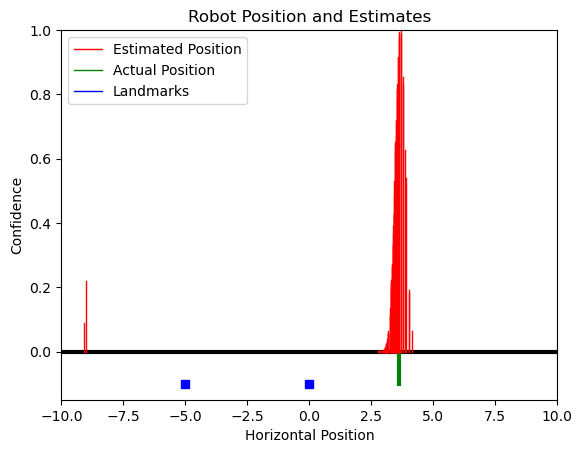

In [5]:
for rob_pos, est_pos in zip(real_poses, est_poses):
    time.sleep(0.1)
    clear_output(wait=True)
    visualize_linear_world(rob_pos, est_pos, landmarks, world_size)